In [1]:
from sedona.spark import *
from pyspark.sql.functions import *
from pyspark.sql.utils import AnalysisException

config = SedonaContext.builder() \
    .getOrCreate()

sedona = SedonaContext.create(config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Setting Spark log level to "WARN".


# Recommended runtime

## Tiny

# Cost: 

Cost of executing this over King County.

- **~$6**

Cost of executing this over Kirkland.

- **>$1**

# NDVI

Find average NDVI over 500m radius of the house.

## **NDVI** Formula

($\frac{\mathrm{NIR} - \mathrm{RED}}{\mathrm{NIR} + \mathrm{RED}}$)

### Bands used 
- RED   / B04
- NIR   / B08


Make sure to filter out the unnecessary rasters outside of King County.


```python
import wkls

_aoi = wkls.us.wa.kingcounty.wkt()
```

In [2]:
import wkls

_aoi = wkls.us.wa.kirkland.wkt()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Trying to enrich the existing `house_sales_silver` table, if not avaliable then falling back to the bronze table.

In [13]:
try:
    print("Trying to load house_sales_silver dataset from gde_silver database\n\n")
    house_sales_df = (
        sedona.table(f"org_catalog.gde_silver.house_sales_silver")
                .where(f"ST_Intersects(geometry, ST_GeomFromWKT('{_aoi}'))")
                .withColumn("geometry_buffer", expr("ST_Buffer(geometry, 500, true)"))
    )
    print("house_sales_silver dataset found and loaded.\n\n")
except AnalysisException as e:
    print("house_sales_silver table doesn't exist, reading the gde_bronze.house_sales_bronze\n\n")

    house_sales_df = (
        sedona.table(f"org_catalog.gde_bronze.house_sales_bronze")
                .where(f"ST_Intersects(geometry, ST_GeomFromWKT('{_aoi}'))")
                .withColumn("geometry_buffer", expr("ST_Buffer(geometry, 500, true)"))
    )


house_sales_df.createOrReplaceTempView("house_sales")
house_sales_df.show()

Trying to load house_sales_silver dataset from gde_silver database


house_sales_silver dataset found and loaded.


+------+-----------+------------+----------+----------+--------+------------+----------------+---------+----------------+-----------------+----+--------+-------+--------------------+-----------+--------+-------+----------+---------+--------+----+------+----------+-----+-----------+---------+-------+----+---------+---------+---------+---------+---------+----+----+---------+-------------+------------+-------------+-------------+----------------+------------+----------+-------------+-------------+---------------+----------+---------+--------------------+---------------------+--------------------+
|   _c0|    sale_id|        pinx| sale_date|sale_price|sale_nbr|sale_warning|     join_status|join_year|        latitude|        longitude|area|    city| zoning|         subdivision|present_use|land_val|imp_val|year_built|year_reno|sqft_lot|sqft|sqft_1|sqft_fbsmt|grade|fbsmt_grade|c

# Reading in the sentinel 2 dataset using the STAC API

In [4]:
from pyspark.sql.functions import col, explode, map_values

# Load from STAC datasource
df = (sedona.read.format("stac") 
    .option("itemsLimitMax", "1000") 
    .option("itemsLimitPerRequest", "200") 
    .load("https://earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a")  # STAC Endpoint
    .where(f"ST_INTERSECTS(geometry, ST_GeomFromWKT('{_aoi}'))")                      # Apply Spatial Filter
    .withColumn("rast_nir", expr("assets.nir.rast"))                                  # Promote the NIR band
    .withColumn("rast_red", expr("assets.red.rast"))                                  # Promote the Red band
    .select("id",                                                                     #--------------------
            expr("date(datetime)"),                                                   #
            col("eo:cloud_cover").alias("cloud_cover"),                               #
            col("grid:code").alias("grid_code"),                                      #
            "geometry",                                                               # Select Attributes
            "rast_red",                                                               #
            "rast_nir",                                                               #
            "platform",                                                               #
            "constellation",                                                          #--------------------
           )
    .filter("cloud_cover <  10")                                                      #Apply the cloud cover filter
    .filter("DATE(datetime) between '2024-06-01' and'2024-07-31'")                    #Apply Date Range Filter
    .orderBy(expr("date(datetime)"))
    .repartition(1_000)
    .cache()
     )
df.createOrReplaceTempView("asset_items")
df.show()

+--------------------+----------+-----------+----------+--------------------+--------------------+--------------------+-----------+-------------+
|                  id|  datetime|cloud_cover| grid_code|            geometry|            rast_red|            rast_nir|   platform|constellation|
+--------------------+----------+-----------+----------+--------------------+--------------------+--------------------+-----------+-------------+
|S2B_T10TET_202407...|2024-07-10|   0.002056|MGRS-10TET|POLYGON ((-122.79...|LazyLoadOutDbGrid...|LazyLoadOutDbGrid...|sentinel-2b|   sentinel-2|
|S2B_T10TET_202407...|2024-07-13|    3.79E-4|MGRS-10TET|POLYGON ((-123.00...|LazyLoadOutDbGrid...|LazyLoadOutDbGrid...|sentinel-2b|   sentinel-2|
|S2A_T10TET_202407...|2024-07-08|   0.001423|MGRS-10TET|POLYGON ((-123.00...|LazyLoadOutDbGrid...|LazyLoadOutDbGrid...|sentinel-2a|   sentinel-2|
|S2A_T10TET_202406...|2024-06-25|   0.002617|MGRS-10TET|POLYGON ((-122.80...|LazyLoadOutDbGrid...|LazyLoadOutDbGrid...|senti

,raster_image1
0,
1,
2,
3,
4,

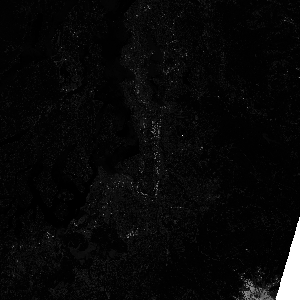
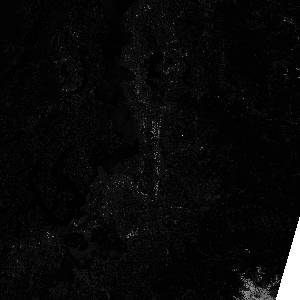
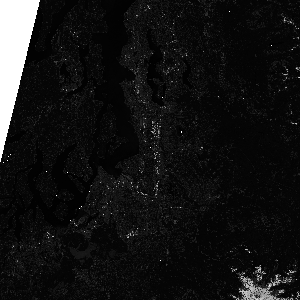
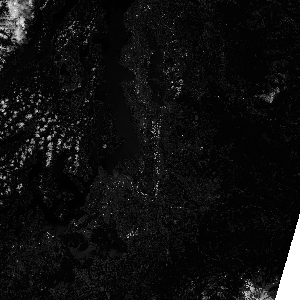
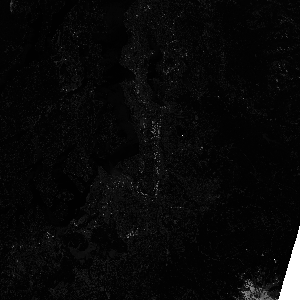

In [5]:
dfImage = df.limit(5) \
    .selectExpr("RS_AsImage(rast_red, 300) as raster_image1")

# Display the image
SedonaUtils.display_image(dfImage)

## Stacking the Red and NIR bands into one raster

In [6]:
tile_size = 512
stackTileExploded_df = sedona.sql(f'''
   with exp as ( SELECT *, 
        RS_StackTileExplode(Array(rast_red, 
                                  rast_nir
                                  ),
                            0, 
                            {tile_size}, {tile_size},
                            false)
    FROM asset_items
    )
    SELECT
        id,
        x,
        y,
        datetime,
        grid_code,
        tile as rast,
        RS_ENVELOPE(tile) as geometry,
        RS_NumBands(tile) as band_cnt
    FROM 
        exp
''')

stackTileExploded_df = stackTileExploded_df.repartition(1000)

from pyspark.storagelevel import StorageLevel
stackTileExploded_df = stackTileExploded_df.persist(StorageLevel.DISK_ONLY)
print("Count:", stackTileExploded_df.count())
stackTileExploded_df.createOrReplaceTempView("tiled_raster")

Count: 4356
CPU times: user 145 ms, sys: 21.2 ms, total: 166 ms
Wall time: 2min 41s


## Calculating NDVI index

In [7]:
ndvi_house = sedona.sql("""

WITH ndvi_raster AS (
SELECT
        a.geometry_buffer,
        a.sale_id,
        ndvi
FROM
    house_sales a
JOIN
    (SELECT
       geometry,
       datetime,
       RS_MapAlgebra(rast, 'D', 'out = (rast[1] > 0 && rast[0] > 0) ? (rast[1] - rast[0]) / (rast[1] + rast[0]) : null;') as ndvi
     FROM tiled_raster
     WHERE NOT isnan(RS_SummaryStats(rast,'max'))) b
ON
   ST_Intersects(b.geometry,ST_TRANSFORM(a.geometry_buffer,"EPSG:4269","EPSG:32610"))
),
zonal_stats (
SELECT
    RS_ZONALSTATS(ndvi,geometry_buffer,'mean') mean_ndvi,
    sale_id
FROM
    ndvi_raster
)

SELECT 
    AVG(mean_ndvi) AS mean_ndvi,
    sale_id
FROM
    zonal_stats
GROUP BY
    sale_id

""").cache() # Caching the result as I will be using the result more than once. When converting this into a job, please remove .cache(), .count(), and .show() below

ndvi_house.show()

+-------------------+-----------+
|          mean_ndvi|    sale_id|
+-------------------+-----------+
| 0.7318427171303145|2011..17161|
| 0.7360554886481115|2021..22738|
| 0.5146695215757258|2010..19689|
| 0.5227414910176201|2001..17971|
| 0.5526299225643422|2000..23554|
| 0.5338479396692295|2020..40616|
| 0.4268456974128393|2024..10740|
|  0.482239719007718| 2001..6186|
| 0.4917856133484566| 2017..4895|
| 0.6690210796731001|2001..20495|
| 0.6235261079628428|2014..32250|
| 0.6275599726216556| 2006..5831|
| 0.5409532099649613|2013..13866|
| 0.5447648821416424|2005..12747|
| 0.5868247052822613|2015..26319|
|0.33791284778639347|2000..10183|
|0.49960269815508557|2002..35898|
| 0.5817976677341012| 2018..4196|
| 0.6083711803772481|  2002..942|
| 0.5257362294096452|2015..43885|
+-------------------+-----------+
only showing top 20 rows

CPU times: user 223 ms, sys: 48.3 ms, total: 271 ms
Wall time: 2min 41s


In [8]:
ndvi_house.createOrReplaceTempView("ndvi_house")

In [9]:
ndvi_house.count()

26221

In [23]:
database = "gde_silver"

In [33]:
sedona.sql(f"CREATE DATABASE IF NOT EXISTS org_catalog.{database}").show()

++
||
++
++



In [24]:
sedona.sql("""

SELECT 
    a.*,
    b.mean_ndvi as mean_ndvi_500m_radius
FROM
    house_sales a
JOIN
    ndvi_house b
ON
    a.sale_id = b.sale_id

""").drop("geometry_buffer").writeTo(f"org_catalog.{database}.house_sales_silver").createOrReplace()